In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import io
import sagemaker.amazon.common as smac

import boto3
from sagemaker import get_execution_role
import sagemaker

import matplotlib.pyplot as plt
import seaborn as sns


Load data from S3 bucket

In [2]:
role = get_execution_role()
bucket = 'ml-labs-saras'
sub_folder = 'UFO-dataset'
data_key = 'UFO-fullset.csv'

data_location = 's3://{}/{}/{}'.format(bucket, sub_folder, data_key)

df = pd.read_csv(data_location, low_memory=False)
df.head()


,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04T04:02:23.340Z,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22T02:06:32.019Z,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,Y,N,explained
2,1992-12-07T19:06:52.482Z,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,N,N,explained
3,2011-02-24T21:06:34.898Z,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,N,N,explained
4,1991-03-09T16:18:45.501Z,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,N,N,explained


Cleaning, transforming, analying and preparing dataset

In [3]:
#Looking for missing values
missing_values = df.isnull().values.any()
if(missing_values):
    display(df[df.isnull().any(axis=1)])
    

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
1024,2011-03-23T18:32:20.473Z,2011-03-22,21:12,NaN,3,1,rain,Deon,Feil,37.681944,-121.766944,Y,N,N,explained
2048,1998-04-23T18:47:16.029Z,1998-04-23,10:07,NaN,40,2,partly cloudy,Vincenzo,Rohan,38.254167,-85.759444,Y,Y,N,explained


In [4]:
df['shape'].value_counts()

circle      6047
disk        5920
light       1699
square      1662
triangle    1062
sphere      1020
box          200
oval         199
pyramid      189
Name: shape, dtype: int64

I'm trying to see a coount of each shape in the dataset and replace those missing values with the most common shape.

In [5]:
df['shape'] = df['shape'].fillna(df['shape'].value_counts().index[0])

Convert reportTimestamp and eventDate to datetime datatype

Convert shape and whether to categorical data

Map physicalEvidence and contact 'Y/N' to 0 and 1s

Convert researchOutcome to categorical data


In [6]:
df['reportedTimestamp'] = pd.to_datetime(df['reportedTimestamp'])
df['eventDate'] = pd.to_datetime(df['eventDate'])

df.head()

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04 04:02:23.340000+00:00,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22 02:06:32.019000+00:00,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,Y,N,explained
2,1992-12-07 19:06:52.482000+00:00,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,N,N,explained
3,2011-02-24 21:06:34.898000+00:00,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,N,N,explained
4,1991-03-09 16:18:45.501000+00:00,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,N,N,explained


In [7]:
df['shape'] = df['shape'].astype('category')
df['weather'] = df['weather'].astype('category')

df.head()

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04 04:02:23.340000+00:00,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22 02:06:32.019000+00:00,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,Y,N,explained
2,1992-12-07 19:06:52.482000+00:00,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,N,N,explained
3,2011-02-24 21:06:34.898000+00:00,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,N,N,explained
4,1991-03-09 16:18:45.501000+00:00,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,N,N,explained


In [8]:
df['physicalEvidence'] = df['physicalEvidence'].replace({'Y' : 1, 'N' : 0})
df['contact'] =df['contact'].replace({'Y' : 1, 'N' : 0})

df.head()

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04 04:02:23.340000+00:00,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,0,0,explained
1,1982-11-22 02:06:32.019000+00:00,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,1,0,explained
2,1992-12-07 19:06:52.482000+00:00,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,0,0,explained
3,2011-02-24 21:06:34.898000+00:00,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,0,0,explained
4,1991-03-09 16:18:45.501000+00:00,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,0,0,explained


In [9]:
df['researchOutcome'] = df['researchOutcome'].astype('category')

In [10]:
df.dtypes

reportedTimestamp    datetime64[ns, UTC]
eventDate                 datetime64[ns]
eventTime                         object
shape                           category
duration                           int64
witnesses                          int64
weather                         category
firstName                         object
lastName                          object
latitude                         float64
longitude                        float64
sighting                          object
physicalEvidence                   int64
contact                            int64
researchOutcome                 category
dtype: object

Visualize data to understand data

In [11]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

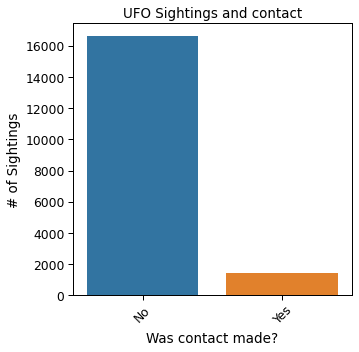

In [12]:
m_cts = (df['contact'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.to_numpy()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and contact')
ax.set_xlabel('Was contact made?')
ax.set_ylabel('# of Sightings')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

How many sightings had physical evidence?

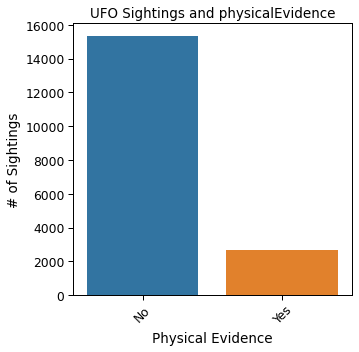

In [13]:
m_cts = (df['physicalEvidence'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.to_numpy()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and physicalEvidence')
ax.set_xlabel('Physical Evidence')
ax.set_ylabel('# of Sightings')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

Looking at distribution of different shapes

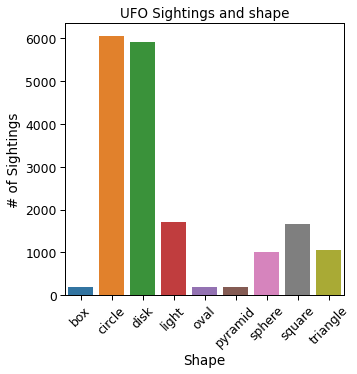

In [14]:
m_cts = (df['shape'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.to_numpy()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and shape')
ax.set_xlabel('Shape')
ax.set_ylabel('# of Sightings')
#ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

looking at distribution of weather

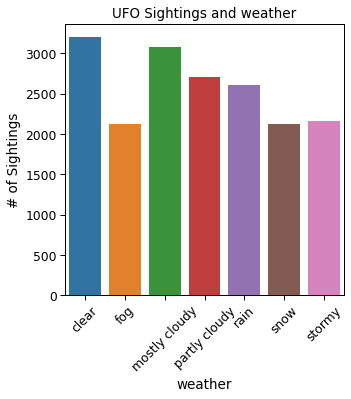

In [15]:
m_cts = (df['weather'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.to_numpy()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and weather')
ax.set_xlabel('weather')
ax.set_ylabel('# of Sightings')
#ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

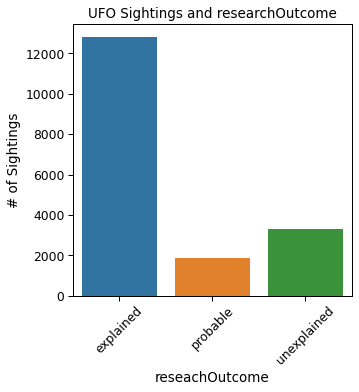

In [16]:
m_cts = (df['researchOutcome'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.to_numpy()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and researchOutcome')
ax.set_xlabel('reseachOutcome')
ax.set_ylabel('# of Sightings')
#ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

Distribution of sightings per year

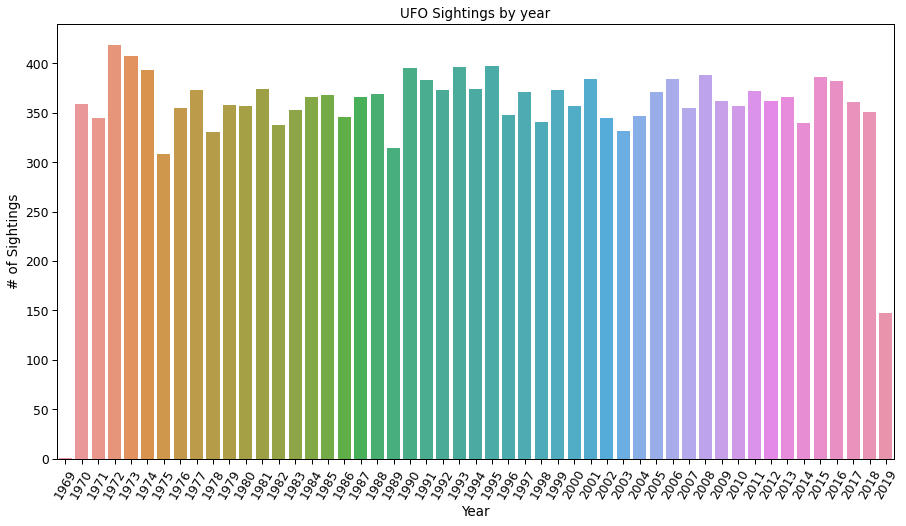

In [17]:
ufo_yr= df['eventDate'].dt.year

#set axes
years_data = ufo_yr.value_counts()
years_index = years_data.index
years_values = years_data.to_numpy()

#Create barplot
plt.figure(figsize=(15,8))
plt.xticks(rotation = 60)

plt.title('UFO Sightings by year')
plt.xlabel('Year')
plt.ylabel('# of Sightings')

years_plot = sns.barplot(x=years_index[:60], y=years_values[:60])
#plt.show()

See correlation of values - shows only numeric correction

In [18]:
df.corr()

,duration,witnesses,latitude,longitude,physicalEvidence,contact
duration,1.000000,0.020679,0.000243,-0.010529,0.016430,0.015188
witnesses,0.020679,1.000000,0.010229,0.003449,0.009186,-0.000651
latitude,0.000243,0.010229,1.000000,-0.394536,0.006465,0.004284
longitude,-0.010529,0.003449,-0.394536,1.000000,-0.004519,-0.004828
physicalEvidence,0.016430,0.009186,0.006465,-0.004519,1.000000,0.693276
contact,0.015188,-0.000651,0.004284,-0.004828,0.693276,1.000000


Above shows a strong correlation between physicalEvidence and contact - whenever there was contact, there was physical evidence atleast 69% of the times. So we will inlcude both these features in our training data. Shape and weather will also be included in the training data

Drop unimportant columns

In [19]:
df.drop(columns = ['firstName', 'lastName', 'sighting', 'reportedTimestamp', 'eventDate', 'eventTime'], inplace=True)

In [20]:
df.head()

,shape,duration,witnesses,weather,latitude,longitude,physicalEvidence,contact,researchOutcome
0,circle,4,1,rain,47.329444,-122.578889,0,0,explained
1,disk,4,1,partly cloudy,52.664913,-1.034894,1,0,explained
2,circle,49,1,clear,38.951667,-92.333889,0,0,explained
3,disk,13,1,partly cloudy,41.496944,-71.367778,0,0,explained
4,circle,17,1,mostly cloudy,47.606389,-122.330833,0,0,explained


Algorith expects only numeric inputs, apply one-hot encoding on shape, weather. 

In [23]:
df = pd.get_dummies(df, columns = ['weather', 'shape'])

df['researchOutcome'] = df['researchOutcome'].replace({'unexplained' : 0, 'explained' : '1', 'probable' : '2'})


In [25]:
df.head()

,duration,witnesses,latitude,longitude,physicalEvidence,contact,researchOutcome,weather_clear,weather_fog,weather_mostly cloudy,...,weather_stormy,shape_box,shape_circle,shape_disk,shape_light,shape_oval,shape_pyramid,shape_sphere,shape_square,shape_triangle
0,4,1,47.329444,-122.578889,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,4,1,52.664913,-1.034894,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,49,1,38.951667,-92.333889,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,13,1,41.496944,-71.367778,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,17,1,47.606389,-122.330833,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0


Randomize data and split into training (80%), validation/test (10% each)

In [26]:
df = df.sample(frac=1).reset_index(drop=True)

rand_split = np.random.rand(len(df))
train_list = rand_split < 80
val_list = (rand_split >=0.8) & (rand_split <=0.9)
test_list = rand_split >= 0.9

data_train = df[train_list]
data_val = df[val_list]
data_test = df[test_list]



Rearrange Attributes so target atrribute = researchOutcome is the first attribute in out inpput data and then store this in our notebook instance as a csv and then load it on to S3.

In [43]:
#moves researchOutcome to the first position before creating any csv files
pd.concat([data_train['researchOutcome'], data_train.drop(['researchOutcome'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([data_val['researchOutcome'], data_val.drop(['researchOutcome'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

#upload csv files to S3
boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/xgboost_train/train.csv').upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/xgboost_validation/validation.csv').upload_file('validation.csv')

Creating and training our model

In [44]:
#get the container for xgboost hosted in ecr
from sagemaker import image_uris
container = image_uris.retrieve('xgboost', boto3.Session().region_name, '1')

Create inputs for the model

In [45]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/algorithms_lab/xgboost_train'.format(bucket), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/algorithms_lab/xgboost_validation'.format(bucket), content_type='csv')

Build model = creating a job name first,
specify training parameters for XGBoost:

The xgboost algorithm container
The IAM role to use
Training instance type and count
S3 location for output data/model artifact
XGBoost Hyperparameters

Finally, after everything is included and ready, then we can call the .fit() function which specifies the S3 location for training and validation data.

In [46]:
# Create a training job name
job_name = 'ufo-xgboost-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Here is the job name {}'.format(job_name))

# Here is where the model artifact will be stored
output_location = 's3://{}/xgboost_output'.format(bucket)
print('Here is the otput l;ocation {}'.format(output_location))

Here is the job name ufo-xgboost-job-20211210112010
Here is the otput l;ocation s3://ml-labs-saras/xgboost_output


In [47]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)

xgb.set_hyperparameters(objective='multi:softmax',
                        num_class=3,
                        num_round=100)

data_channels = {
    'train': s3_input_train,
    'validation': s3_input_validation
}
xgb.fit(data_channels, job_name=job_name) 

2021-12-10 11:20:16 Starting - Starting the training job...
2021-12-10 11:20:42 Starting - Launching requested ML instancesProfilerReport-1639135216: InProgress
......
2021-12-10 11:21:42 Starting - Preparing the instances for training............
2021-12-10 11:23:43 Downloading - Downloading input data
2021-12-10 11:23:43 Training - Downloading the training image...
2021-12-10 11:24:17 Uploading - Uploading generated training modelArguments: train
[2021-12-10:11:24:02:INFO] Running standalone xgboost training.
[2021-12-10:11:24:02:INFO] File size need to be processed in the node: 1.32mb. Available memory size in the node: 8358.25mb
[2021-12-10:11:24:02:INFO] Determined delimiter of CSV input is ','
[11:24:02] S3DistributionType set as FullyReplicated
[11:24:02] 18000x22 matrix with 396000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-12-10:11:24:02:INFO] Determined delimiter of CSV input is ','
[11:24:02] S3DistributionType set as FullyReplic